# 📱 Mobile Price Classification

<img src='https://drive.google.com/uc?export=download&id=1piBH7Pt99VukwvROgsMlxHuKV3Z4P7Fe'>

Given *data about mobile phones*, let's try to predict the **class range** of new phones.

It is a classification problem, not a regression one.

# Getting Started 

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import cross_val_score

In [2]:
data_train = pd.read_csv('../input/mobile-price-classification/train.csv')
data_test = pd.read_csv('../input/mobile-price-classification/test.csv')

In [3]:
data_train.head(2)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2


In [4]:
data_test.head(2)

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0
1,2,841,1,0.5,1,4,1,61,0.8,191,5,12,746,857,3895,6,0,7,1,0,0


# Data Exploration

In [5]:
print("Missing values in the train set:", data_train.isna().sum().sum())
print("Missing values in the test set:", data_test.isna().sum().sum())

Missing values in the train set: 0
Missing values in the test set: 0


There are no missing values in both sets.

In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

All features are numerical.

In [7]:
data_train['price_range'].value_counts()

1    500
2    500
3    500
0    500
Name: price_range, dtype: int64

The classes are perfectly balanced.

In [8]:
# Correlated columns
corr_cols_order = data_train.corr()['price_range'].sort_values(ascending=False).index
corr_cols_order

Index(['price_range', 'ram', 'battery_power', 'px_width', 'px_height',
       'int_memory', 'sc_w', 'pc', 'three_g', 'sc_h', 'fc', 'talk_time',
       'blue', 'wifi', 'dual_sim', 'four_g', 'n_cores', 'm_dep', 'clock_speed',
       'mobile_wt', 'touch_screen'],
      dtype='object')

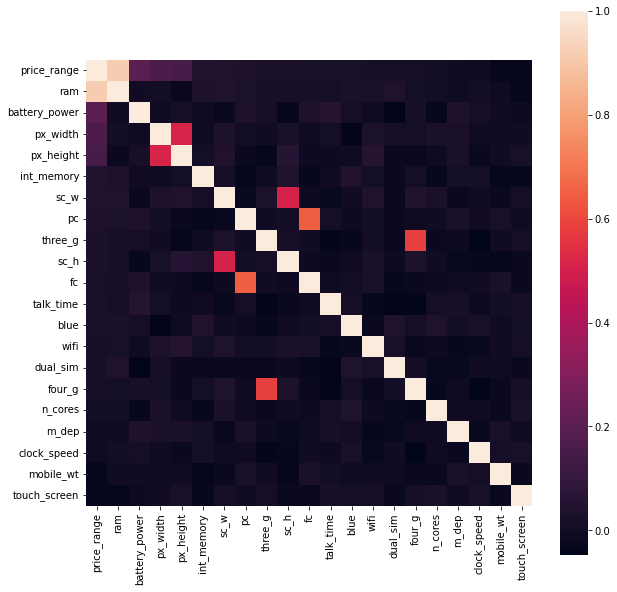

In [9]:
plt.figure(figsize=(10, 10))
sns.heatmap(data_train[corr_cols_order].corr(), square=True)
plt.show()

# Preprocessing

The preprocessing function will transform the raw datasets into model-friendly formats.

Since train and test sets are already separated, we must give both datasets as inputs.

Here, the test set is not labeled like it is supposed to be in a real world problem. This is why we will use cross validation on the training set.

In [10]:
def preprocess_inputs(df_train, df_test):
    
    # Features
    features = ['ram', 'battery_power', 'px_width', 'px_height', 'int_memory', 'sc_w', 'pc',
                'three_g', 'sc_h', 'fc', 'talk_time', 'blue', 'wifi', 'dual_sim', 'four_g',
                'n_cores', 'm_dep', 'clock_speed', 'mobile_wt', 'touch_screen']

    # Split X and y
    X_train = df_train[features]
    X_test = df_test[features]
    y_train = df_train['price_range']
    
    # Scale X
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    return X_train, X_test, y_train

In [11]:
X_train, X_test, y_train = preprocess_inputs(data_train, data_test)

# Modeling

In [12]:
models = {
    "      KNN" : KNeighborsClassifier(),
    "     Tree" : DecisionTreeClassifier(),
    "       RF" : RandomForestClassifier(),
    "GradBoost" : GradientBoostingClassifier(),
    "  XGBoost" : XGBClassifier(),
    " LightGBM" : LGBMClassifier(),
    " CatBoost" : CatBoostClassifier(verbose=0)
}

for name, model in models.items():
    cv_results = cross_val_score(model, X_train, y_train, cv=5)
    print(name, "scores:", cv_results)
    print("         Average: {:.3f}".format(cv_results.mean()))
    print("-------------------------------------------------------")

      KNN scores: [0.5   0.51  0.51  0.525 0.47 ]
         Average: 0.503
-------------------------------------------------------
     Tree scores: [0.8275 0.8075 0.8275 0.7925 0.8175]
         Average: 0.815
-------------------------------------------------------
       RF scores: [0.8525 0.8475 0.8825 0.845  0.84  ]
         Average: 0.854
-------------------------------------------------------
GradBoost scores: [0.87   0.8825 0.8725 0.865  0.87  ]
         Average: 0.872
-------------------------------------------------------
  XGBoost scores: [0.86   0.885  0.9075 0.8625 0.86  ]
         Average: 0.875
-------------------------------------------------------
 LightGBM scores: [0.86   0.8725 0.8975 0.8675 0.8675]
         Average: 0.873
-------------------------------------------------------
 CatBoost scores: [0.87   0.885  0.915  0.8725 0.875 ]
         Average: 0.884
-------------------------------------------------------


The best model is the CatBoost!

**Note:** Usually, it is better to fit the scaler on the training data only and not on the validation test. It is data leakage otherwise.

# Testing

Now we have a decent model, we can do the predictions on the test set. However, we will not be able to verify these predictions since the data is not labeled. But we can expect a score similar to what we had in the modeling part.

Previously, each model was trained with only 4 folds (80%). We can now retrain the CatBoost model with 100% of the training data.

In [13]:
model = CatBoostClassifier(verbose=0)
model.fit(X_train, y_train)

In [14]:
y_test = model.predict(X_test)
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

{0: 253, 1: 228, 2: 266, 3: 253}


Thank you for reading, please let me know if you have any suggestion.